# Task 2: Multi Product with B constrain


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

# Environment Setup

In this notebook, we implement a Combinatorial UCB algorithm for multi-product pricing with inventory constraints.

The scenario involves:
- Multiple products with different customer valuation distributions
- Limited inventory for each product
- Combinatorial action space where we select a subset of products to offer
- Goal: Maximize revenue while respecting inventory constraints

In [109]:
class MultiProductPricingEnvironment:
    """
    Multi-product stochastic environment for dynamic pricing with inventory constraints.

    This environment simulates a multi-product pricing scenario where:
    - Each product has its own customer valuation distribution
    - Customers have different preferences for different products
    - Each round represents one customer interaction
    - The customer can purchase multiple products or none at all
    """
    def __init__(self, valuation_distributions, correlation_matrix=None):
        """
        Initialize the multi-product pricing environment.

        Args:
            valuation_distributions: List of scipy.stats distributions for each product
            correlation_matrix: Optional correlation matrix for product valuations
        """
        self.valuation_dists = valuation_distributions
        self.n_products = len(valuation_distributions)
        self.correlation_matrix = correlation_matrix

        # If no correlation matrix provided, assume independence
        if correlation_matrix is None:
            self.correlation_matrix = np.eye(self.n_products)

    def demand_probability(self, prices, product_subset):
        """
        Calculate the theoretical probability that a customer purchases
        the given subset of products at given prices.

        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered

        Returns:
            Probability that customer will purchase this product subset
        """
        if len(product_subset) == 0:
            return 0.0

        # For simplicity, assume independent purchase decisions
        # In practice, this could be more complex with substitution effects
        prob = 1.0
        for product_idx in product_subset:
            # Probability that customer values this product >= its price
            product_prob = 1 - self.valuation_dists[product_idx].cdf(prices[product_idx])
            prob *= product_prob

        return prob

    def simulate_round(self, prices, product_subset):
        """
        Simulate one customer interaction for a given product subset and prices.

        Args:
            prices: Array of prices for each product
            product_subset: List of product indices being offered

        Returns:
            tuple: (products_purchased, total_revenue) where:
                - products_purchased: List of products actually purchased
                - total_revenue: Sum of revenues from purchased products
        """
        if len(product_subset) == 0:
            return [], 0.0

        products_purchased = []
        total_revenue = 0.0

        # Generate customer valuations for all products
        valuations = np.array([dist.rvs() for dist in self.valuation_dists])

        # Customer purchases products where valuation >= price
        for product_idx in product_subset:
            if valuations[product_idx] >= prices[product_idx]:
                products_purchased.append(product_idx)
                total_revenue += prices[product_idx]

        return products_purchased, total_revenue

# Combinatorial UCB Agent with LP-based Inventory Constraints

In [110]:
class CombinatorialUCBWithInventory:
    """
    Combinatorial UCB agent for multi-product pricing with inventory constraints.

    This agent implements a combinatorial bandit approach where:
    1. Actions are product-price combinations for each product
    2. Each product has limited inventory
    3. UCB confidence bounds guide exploration vs exploitation
    4. Linear programming optimizes the product-price selection considering inventory constraints
    5. Uses LP-based action selection similar to single-product UCB but extended to multiple products
    """

    def __init__(self, n_products, price_options, inventory_per_product, T,
                 confidence_bound=1.0, rho_penalty=1.0, use_pen_rho=True):
        """
        Initialize the combinatorial UCB agent with LP-based action selection.

        Args:
            n_products: Number of products
            price_options: List of possible prices for each product
            inventory_per_product: Initial inventory for each product
            T: Time horizon (number of rounds)
            confidence_bound: UCB confidence parameter
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
            use_pen_rho: Whether to use penalty factor for inventory constraints
        """
        self.n_products = n_products
        self.price_options = np.array(price_options)
        self.T = T
        self.confidence_bound = confidence_bound
        self.rho_penalty = rho_penalty
        self.use_pen_rho = use_pen_rho

        # Inventory management
        self.initial_inventory = np.array(inventory_per_product, dtype=float)
        self.remaining_inventory = np.array(inventory_per_product, dtype=float)

        # Target selling rates for each product
        self.rho = self.initial_inventory / T  # Target selling rate per product

        # Statistics for each (product, price) combination
        self.n_price_options = len(price_options)
        self.avg_revenue = np.zeros((n_products, self.n_price_options))
        self.avg_purchase_prob = np.zeros((n_products, self.n_price_options))
        self.n_pulls = np.zeros((n_products, self.n_price_options))

        # Current state
        self.t = 0
        self.current_action_indices = None  # price indices for each product

        # History tracking
        self.history = {
            'actions': [],
            'revenues': [],
            'purchases': [],
            'inventory_levels': [],
            'price_distributions': []  # Store computed price distributions
        }

    def select_action(self):
        """
        Select actions for each product using LP-based UCB with inventory constraints.

        For each product with remaining inventory:
        1. Compute UCB bounds on revenue and LCB bounds on purchase probability
        2. Solve LP to get optimal price distribution for that product
        3. Sample price according to the distribution

        Returns:
            tuple: (product_subset, prices) where:
                - product_subset: List of product indices with inventory
                - prices: List of selected prices for each product
        """
        product_subset = []
        prices = []
        action_map = {}  # Maps product_idx to price_idx

        # Process each product independently
        for product_idx in range(self.n_products):
            if self.remaining_inventory[product_idx] < 1:
                continue  # Skip products with no inventory

            # Select price for this product using LP
            price_idx = self._select_price_for_product(product_idx)

            if price_idx is not None:
                product_subset.append(product_idx)
                prices.append(self.price_options[price_idx])
                action_map[product_idx] = price_idx

        # Store current action for update
        self.current_action_map = action_map

        return product_subset, prices

    def _select_price_for_product(self, product_idx):
        """
        Select price for a single product using LP-based UCB approach.

        Args:
            product_idx: Index of the product

        Returns:
            Selected price index, or None if no valid price
        """
        # Exploration phase: try each price at least once
        if self.t < self.n_price_options * self.n_products:
            # Round-robin exploration across all product-price combinations
            exploration_idx = self.t % (self.n_price_options * self.n_products)
            target_product = exploration_idx // self.n_price_options
            target_price = exploration_idx % self.n_price_options

            if target_product == product_idx:
                return target_price
            else:
                # If not this product's turn, select based on current knowledge
                if np.sum(self.n_pulls[product_idx, :]) == 0:
                    return 0  # Select first price if never tried
                else:
                    return np.argmax(self.avg_revenue[product_idx, :])

        # LP-based exploitation phase
        # Compute UCB bounds on revenue
        confidence_radius = self.confidence_bound * np.sqrt(
            2 * np.log(max(1, self.t)) / np.maximum(self.n_pulls[product_idx, :], 1)
        )
        f_ucbs = self.avg_revenue[product_idx, :] + confidence_radius

        # Compute LCB bounds on purchase probability
        demand_confidence_radius = self.confidence_bound * np.sqrt(
            2 * np.log(max(1, self.t)) / np.maximum(self.n_pulls[product_idx, :], 1)
        )
        c_lcbs = np.maximum(0, self.avg_purchase_prob[product_idx, :] - demand_confidence_radius)

        # Solve LP to get optimal price distribution for this product
        gamma_t = self._compute_optimal_distribution(product_idx, f_ucbs, c_lcbs)

        # Sample price according to computed distribution
        price_idx = np.random.choice(self.n_price_options, p=gamma_t)

        return price_idx

    def _compute_optimal_distribution(self, product_idx, f_ucbs, c_lcbs):
        """
        Solve LP to find optimal price distribution for a single product with inventory constraints.

        Formulation for product k:
        maximize: sum_i gamma_i * f_ucb_i (expected revenue for product k)
        subject to: sum_i gamma_i * c_lcb_i <= current_rho_k (inventory constraint for product k)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)

        Args:
            product_idx: Index of the product
            f_ucbs: Upper confidence bounds on revenue for each price
            c_lcbs: Lower confidence bounds on purchase probability for each price

        Returns:
            gamma: Probability distribution over prices for this product
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(c_lcbs <= 1e-10):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma

        # Convert to minimization problem (negate revenues)
        c = -f_ucbs

        # Compute current required selling rate for this product
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory[product_idx] / remaining_rounds, 0)

        # Linear program constraints
        A_ub = [c_lcbs]  # Inventory constraint coefficients

        if self.use_pen_rho:
            # Apply penalty to make constraint more conservative
            inventory_ratio = self.remaining_inventory[product_idx] / self.initial_inventory[product_idx]
            time_ratio = (self.T - self.t) / self.T

            if inventory_ratio > 0.5 and time_ratio > 0.5:
                # Early stages with plenty of inventory: relax constraint
                penalty_factor = self.rho_penalty * 1.5
            elif inventory_ratio < 0.1:
                # Low inventory: tighten constraint
                penalty_factor = self.rho_penalty * 0.5
            else:
                penalty_factor = self.rho_penalty

            penalized_rho = current_rho * penalty_factor

            # If the constraint is too tight, relax it
            min_demand = np.min(c_lcbs[c_lcbs > 0]) if np.any(c_lcbs > 0) else 0
            if penalized_rho < min_demand * 0.5:
                penalized_rho = min_demand * 0.8

            b_ub = [penalized_rho]
        else:
            b_ub = [current_rho]

        A_eq = [np.ones(self.n_price_options)]  # Probability constraint coefficients
        b_eq = [1]  # Probability constraint bound

        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                                 bounds=[(0, 1) for _ in range(self.n_price_options)], method='highs')
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.n_price_options) / self.n_price_options
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.n_price_options) / self.n_price_options
        except:
            # Fallback: uniform distribution
            return np.ones(self.n_price_options) / self.n_price_options

    def update(self, products_purchased, total_revenue):
        """
        Update agent statistics based on observed outcome.

        Args:
            products_purchased: List of products actually purchased
            total_revenue: Total revenue obtained
        """
        if not hasattr(self, 'current_action_map') or not self.current_action_map:
            return

        # Update statistics for each product that was offered
        for product_idx, price_idx in self.current_action_map.items():
            # Update pull count
            self.n_pulls[product_idx, price_idx] += 1

            # Determine if this specific product was purchased
            was_purchased = product_idx in products_purchased
            price = self.price_options[price_idx]
            revenue_from_product = price if was_purchased else 0.0

            # Update average revenue using incremental mean
            self.avg_revenue[product_idx, price_idx] += (
                revenue_from_product - self.avg_revenue[product_idx, price_idx]
            ) / self.n_pulls[product_idx, price_idx]

            # Update average purchase probability
            purchase_indicator = 1.0 if was_purchased else 0.0
            self.avg_purchase_prob[product_idx, price_idx] += (
                purchase_indicator - self.avg_purchase_prob[product_idx, price_idx]
            ) / self.n_pulls[product_idx, price_idx]

            # Update inventory if product was purchased
            if was_purchased and self.remaining_inventory[product_idx] > 0:
                self.remaining_inventory[product_idx] -= 1

        # Record history
        product_subset = list(self.current_action_map.keys())
        price_indices = list(self.current_action_map.values())

        self.history['actions'].append((product_subset.copy(), price_indices.copy()))
        self.history['revenues'].append(total_revenue)
        self.history['purchases'].append(products_purchased.copy())
        self.history['inventory_levels'].append(self.remaining_inventory.copy())

        # Increment time
        self.t += 1

    def get_best_strategy(self):
        """
        Return the best strategy learned so far for each product.

        Returns:
            Dictionary with best price and performance for each product
        """
        best_strategies = {}

        for product_idx in range(self.n_products):
            best_price_idx = np.argmax(self.avg_revenue[product_idx, :])
            best_price = self.price_options[best_price_idx]
            best_revenue = self.avg_revenue[product_idx, best_price_idx]
            best_prob = self.avg_purchase_prob[product_idx, best_price_idx]

            best_strategies[product_idx] = {
                'best_price': best_price,
                'avg_revenue': best_revenue,
                'purchase_prob': best_prob,
                'pulls': self.n_pulls[product_idx, best_price_idx]
            }

        return best_strategies

# Combinatorial UCB Agent with LP-based method and a unique Inventory

In [111]:
# We assume that every agent can complete every task (all edges exist)
class UCBMatchingAgent:


    def __init__(self, n_products, price_options, inventory, T,
                 confidence_bound=1.0, rho_penalty=1.0, use_pen_rho=True, selection_method='sampling'):

        self.price_options=price_options
        self.n_products = n_products
        self.n_price_options=len(price_options)
        self.W_avg = np.zeros((n_products,self.n_price_options))
        self.N_pulls = np.zeros((n_products,self.n_price_options))

        self.T = T # not strictly necessary, you can use the anytime version of UCB
        self.t = 0

        # Inventory is now a single value representing total inventory
        self.initial_inventory = inventory
        self.remaining_inventory = inventory

        self.rho = self.initial_inventory / self.T

        self.confidence_bound = confidence_bound
        self.rho_penalty = rho_penalty
        self.use_pen_rho = use_pen_rho

        self.A_t = None
        self.rows_t = None
        self.cols_t = None

        self.selection_method = selection_method

        self.avg_revenue = np.zeros((n_products, self.n_price_options))
        self.avg_purchase_prob = np.zeros((n_products, self.n_price_options))

        # Current state
        self.current_action_indices_map = {}  # Maps product_idx to price_idx for offered products

        # History tracking
        self.history = {
            'actions': [], # Stores (product_subset, price_indices)
            'revenues': [],
            'purchases': [],
            'inventory_levels': [], # This will now store a single value per round
            'price_distributions': []  # Store computed price distributions
        }



    def select_action(self):
        """
        Select actions for each product using LP-based UCB with shared inventory constraints.

        1. Compute UCB bounds on revenue and LCB bounds on purchase probability.
        2. Solve LP to get optimal price distribution for all products considering shared inventory.
        3. Sample prices for each product according to the distribution.

        Returns:
            tuple: (product_subset, prices) where:
                - product_subset: List of product indices with inventory
                - prices: List of selected prices for each product
        """

        # If no inventory remaining, return empty action
        if self.remaining_inventory < 1:
            self.current_action_indices_map = {}
            return [], []

        # if an arm is unexplored, then the UCB is a large value
        W = np.zeros(self.W_avg.shape, dtype=float)
        C = np.zeros(self.avg_purchase_prob.shape, dtype=float)

        large_value = 1e7
        small_value = 1e-7

        W[self.N_pulls==0] = large_value
        C[self.N_pulls==0] = small_value

        mask = self.N_pulls>0

        sigma = self.confidence_bound * np.sqrt(2*np.log(max(1, self.t))/self.N_pulls[mask])

        W[mask] = self.W_avg[mask] + sigma
        C[mask] = np.maximum(self.avg_purchase_prob[mask] - sigma,0)

        Gamma = self.compute_opt(W, C)
        product_subset = []
        prices = []
        self.current_action_indices_map = {} # Reset for this round

        # NEW: Use Linear Sum Assignment to select prices
        #selected_price_indices = self._select_prices_lsa(Gamma, W)
        
        # Option 2: Use original sampling
        # selected_price_indices = self._select_prices_sampling(Gamma)
        
        # Option 3: Use hybrid approach
        # selected_price_indices = self._select_prices_hybrid(Gamma, W, explore_prob=0.1)
        
        # Option 4: Use unified method switcher
        selected_price_indices = self._select_prices(Gamma, W, method=self.selection_method)

        # Build the action using LSA-selected price indices
        for product_idx in range(self.n_products):
            price_idx = selected_price_indices[product_idx]
            
            # Add to action (all products are offered as long as total inventory > 0)
            product_subset.append(product_idx)
            prices.append(self.price_options[price_idx])
            self.current_action_indices_map[product_idx] = price_idx

        return product_subset, prices

    def _select_prices_lsa(self, Gamma, W):
        """
        Use Linear Sum Assignment to select optimal price for each product
        based on gamma-weighted revenues.
        
        Args:
            Gamma: Optimal probability distribution matrix (n_products x n_price_options)
            W: Upper confidence bounds on revenue (n_products x n_price_options)
        
        Returns:
            selected_price_indices: List of price indices for each product
        """
        # Create cost matrix: gamma-weighted revenues
        # Negative because LSA minimizes but we want to maximize revenue
        cost_matrix = -(Gamma * W)  # Element-wise multiplication
        
        # Solve assignment problem
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        return col_indices.tolist()

    # Alternative implementation with exploration probability
    def _select_prices_hybrid(self, Gamma, W, explore_prob=0.1):
        """
        Hybrid approach: use LSA with probability (1-explore_prob), 
        sampling with probability explore_prob.
        
        Args:
            Gamma: Optimal probability distribution matrix (n_products x n_price_options)
            W: Upper confidence bounds on revenue (n_products x n_price_options)
            explore_prob: Probability of using sampling instead of LSA
        
        Returns:
            selected_price_indices: List of price indices for each product
        """
        if np.random.random() < explore_prob:
            # Exploration: use original sampling approach
            selected_price_indices = []
            for product_idx in range(self.n_products):
                prob_dist = Gamma[product_idx, :]
                sum_prob = np.sum(prob_dist)
                if sum_prob > 0:
                    prob_dist /= sum_prob
                else:
                    prob_dist = np.ones(self.n_price_options) / self.n_price_options
                
                price_idx = np.random.choice(self.n_price_options, p=prob_dist)
                selected_price_indices.append(price_idx)
            
            return selected_price_indices
        else:
            # Exploitation: use LSA
            return self._select_prices_lsa(Gamma, W)
    
        
    def _select_prices_sampling(self, Gamma):
        """
        Original sampling approach: sample price for each product according to gamma distribution.
        
        Args:
            Gamma: Optimal probability distribution matrix (n_products x n_price_options)
        
        Returns:
            selected_price_indices: List of price indices for each product
        """
        selected_price_indices = []
        
        for product_idx in range(self.n_products):
            # Ensure the distribution sums to 1 for sampling
            prob_dist = Gamma[product_idx, :]
            sum_prob = np.sum(prob_dist)
            if sum_prob > 0:
                prob_dist /= sum_prob
            else:
                prob_dist = np.ones(self.n_price_options) / self.n_price_options  # Fallback uniform
            
            price_idx = np.random.choice(self.n_price_options, p=prob_dist)
            selected_price_indices.append(price_idx)
        
        return selected_price_indices
    
    # Method switcher for easy comparison
    def _select_prices(self, Gamma, W, method='lsa'):
        """
        Unified method to select prices using different strategies.
        
        Args:
            Gamma: Optimal probability distribution matrix (n_products x n_price_options)
            W: Upper confidence bounds on revenue (n_products x n_price_options)
            method: Selection method ('lsa', 'sampling', 'hybrid')
        
        Returns:
            selected_price_indices: List of price indices for each product
        """
        if method == 'lsa':
            return self._select_prices_lsa(Gamma, W)
        elif method == 'sampling':
            return self._select_prices_sampling(Gamma)
        elif method == 'hybrid':
            return self._select_prices_hybrid(Gamma, W, explore_prob=0.1)
        else:
            raise ValueError(f"Unknown method: {method}. Use 'lsa', 'sampling', or 'hybrid'")

    def compute_opt(self, W, C):
        """
        Solve LP to find optimal price distribution for multiple products with shared inventory constraints.

        Formulation:
        maximize: sum_(k,i) gamma_(k,i) * W_(k,i) (total expected revenue)
        subject to: sum_i gamma_(k,i) = 1 for each product k (probability constraint per product)
                   sum_(k,i) gamma_(k,i) * C_(k,i) <= current_rho_total (shared inventory constraint)
                   gamma_(k,i) >= 0 (non-negativity)

        Args:
            W: Upper confidence bounds on revenue for each (product, price) combination (n_products x n_price_options)
            C: Lower confidence bounds on purchase probability for each (product, price) combination (n_products x n_price_options)

        Returns:
            gamma: Probability distribution over prices for each product (n_products x n_price_options)
        """

        # Number of variables is n_products * n_price_options
        num_vars = self.n_products * self.n_price_options

        # Flatten W and C for LP
        c = -W.flatten()

        # Compute current required selling rate for the shared inventory
        remaining_rounds = max(1, self.T - self.t)
        current_rho_total = max(self.remaining_inventory / remaining_rounds, 0)

        # Inequality constraints (shared inventory)
        A_ub = [C.flatten()]
        b_ub = [current_rho_total]

        # Equality constraints (probability distribution for each product)
        A_eq = np.zeros((self.n_products, num_vars))
        b_eq = np.ones(self.n_products)

        for product_idx in range(self.n_products):
            start_idx = product_idx * self.n_price_options
            end_idx = start_idx + self.n_price_options
            A_eq[product_idx, start_idx:end_idx] = 1

        # Bounds for each variable (gamma_ki between 0 and 1)
        bounds = [(0, 1) for _ in range(num_vars)]

        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                                 bounds=bounds, method='highs')

            if res.success:
                gamma_flat = res.x
                # Reshape gamma back to (n_products, n_price_options)
                gamma = gamma_flat.reshape((self.n_products, self.n_price_options))

                # Ensure valid probability distribution for each product
                for product_idx in range(self.n_products):
                    gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                    sum_gamma = np.sum(gamma[product_idx, :])
                    if sum_gamma > 0:
                         gamma[product_idx, :] /= sum_gamma
                    else:
                         # Fallback: uniform distribution for this product
                         gamma[product_idx, :] = np.ones(self.n_price_options) / self.n_price_options

                return gamma
            else:
                # Fallback: uniform distribution for all products
                return np.ones((self.n_products, self.n_price_options)) / self.n_price_options
        except Exception as e:
            print(f"LP Error: {e}")
            # Fallback: uniform distribution for all products
            return np.ones((self.n_products, self.n_price_options)) / self.n_price_options


    def update(self, products_purchased, total_revenue):
        """
        Update agent statistics based on observed outcome.

        Args:
            products_purchased: List of products actually purchased in this round
            total_revenue: Total revenue obtained in this round
        """
        if not self.current_action_indices_map:
            return

        # Update statistics for each product that was offered (all products are offered if total inventory > 0)
        # Iterate through the products that were *offered* in this round
        for product_idx, price_idx in self.current_action_indices_map.items():

            # Update pull count for this product-price arm
            self.N_pulls[product_idx, price_idx] += 1

            # Determine if this specific product was purchased in this round
            was_purchased = product_idx in products_purchased
            price = price_options[price_idx] # Assuming price_options is globally accessible or passed

            # Update average revenue for this product-price arm
            # Revenue contribution is the price if purchased, 0 otherwise
            revenue_contribution = price if was_purchased else 0.0
            self.W_avg[product_idx, price_idx] += (
                revenue_contribution - self.W_avg[product_idx, price_idx]
            ) / self.N_pulls[product_idx, price_idx]

            # Update average purchase probability for this product-price arm
            purchase_indicator = 1.0 if was_purchased else 0.0
            self.avg_purchase_prob[product_idx, price_idx] += (
                purchase_indicator - self.avg_purchase_prob[product_idx, price_idx]
            ) / self.N_pulls[product_idx, price_idx]

        # Update total remaining inventory based on the number of products purchased in this round
        num_purchased_this_round = len(products_purchased)
        if self.remaining_inventory > 0:
            self.remaining_inventory -= num_purchased_this_round
            self.remaining_inventory = max(0, self.remaining_inventory) # Ensure inventory doesn't go below zero


        # Record history
        # Store the sampled action (product_subset and price indices)
        product_subset = list(self.current_action_indices_map.keys())
        price_indices = list(self.current_action_indices_map.values())
        self.history['actions'].append((product_subset.copy(), price_indices.copy()))

        self.history['revenues'].append(total_revenue)
        self.history['purchases'].append(products_purchased.copy())
        self.history['inventory_levels'].append(self.remaining_inventory) # Store the single inventory value

        # Increment time
        self.t += 1

    def get_best_strategy(self):
        """
        Return the best strategy learned so far for each product based on average revenue.

        Returns:
            Dictionary with best price and performance for each product
        """
        best_strategies = {}

        for product_idx in range(self.n_products):
            # Find the price index with the highest average revenue for this product
            best_price_idx = np.argmax(self.W_avg[product_idx, :])
            best_price = price_options[best_price_idx] # Assuming price_options is globally accessible
            best_revenue = self.W_avg[product_idx, best_price_idx]
            best_prob = self.avg_purchase_prob[product_idx, best_price_idx]

            best_strategies[product_idx] = {
                'best_price': best_price,
                'avg_revenue': best_revenue,
                'purchase_prob': best_prob,
                'pulls': self.N_pulls[product_idx, best_price_idx]
            }

        return best_strategies

# Theoretical Optimal Solution

# Clairvoyant using LSA or Sampling approach

In [126]:

def compute_clairvoyant(prices, environment, T, total_inventory, method='sampling'):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information
    for the multi-product case with a single shared inventory constraint.

    Args:
        prices: List of available prices (assumed to be the same for all products)
        environment: MultiProductPricingEnvironment to get true demand probabilities
        T: Time horizon
        total_inventory: Total shared inventory across all products
        method: 'sampling' for probabilistic sampling, 'lsa' for Linear Sum Assignment

    Returns:
        Dictionary with optimal policy information, including per-product insights.
    """
    n_products = environment.n_products
    n_price_options = len(prices)
    num_vars = n_products * n_price_options

    # Compute true demand probabilities for each (product, price) combination
    demand_probabilities = np.zeros((n_products, n_price_options))
    for product_idx in range(n_products):
        for price_idx, price in enumerate(prices):
            demand_probabilities[product_idx, price_idx] = 1 - environment.valuation_dists[product_idx].cdf(price)

    # Expected revenue per selection for each (product, price) combination
    expected_revenues = np.array(prices) * demand_probabilities

    # Compute optimal gamma distribution (same for both methods)
    gamma_result = compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory)
    
    if gamma_result is None:
        return create_fallback_result(n_products, n_price_options, prices, 
                                    demand_probabilities, expected_revenues)

    gamma = gamma_result['gamma']
    lp_optimal_revenue = gamma_result['lp_optimal_revenue']

    if method == 'sampling':
        return compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                          lp_optimal_revenue, T, n_products, n_price_options)
    elif method == 'lsa':
        return compute_lsa_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                     lp_optimal_revenue, T, n_products, n_price_options)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'sampling' or 'lsa'")

def compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory):
    """
    Solve the LP to get optimal gamma distribution.
    """
    n_products, n_price_options = expected_revenues.shape
    num_vars = n_products * n_price_options

    # Set up linear program (convert maximization to minimization)
    c = -expected_revenues.flatten()

    # Inequality constraints (shared inventory)
    A_ub = [demand_probabilities.flatten()]
    b_ub = [total_inventory / T]

    # Equality constraints (probability distribution for each product)
    A_eq = np.zeros((n_products, num_vars))
    b_eq = np.ones(n_products)

    for product_idx in range(n_products):
        start_idx = product_idx * n_price_options
        end_idx = start_idx + n_price_options
        A_eq[product_idx, start_idx:end_idx] = 1

    bounds = [(0, 1) for _ in range(num_vars)]

    try:
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                              bounds=bounds, method='highs')

        if res.success:
            gamma_flat = res.x
            gamma = gamma_flat.reshape((n_products, n_price_options))
            lp_optimal_revenue = -res.fun * T
            
            return {
                'gamma': gamma,
                'lp_optimal_revenue': lp_optimal_revenue
            }
        else:
            print("Clairvoyant LP failed to converge.")
            return None

    except Exception as e:
        print(f"Clairvoyant LP Error: {e}")
        return None

def compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                               lp_optimal_revenue, T, n_products, n_price_options):
    """
    Compute performance for sampling-based selection (original method).
    """
    optimal_policies = {}
    
    for product_idx in range(n_products):
        best_price_idx_in_dist = np.argmax(gamma[product_idx, :])
        optimal_price_for_product = prices[best_price_idx_in_dist]

        expected_revenue_per_round_product = np.sum(gamma[product_idx, :] * expected_revenues[product_idx, :])
        expected_purchase_prob_product = np.sum(gamma[product_idx, :] * demand_probabilities[product_idx, :])

        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],
            'representative_optimal_price': optimal_price_for_product,
            'expected_revenue_per_round': expected_revenue_per_round_product,
            'purchase_probability': expected_purchase_prob_product,
            'expected_total_revenue_under_dist': expected_revenue_per_round_product * T
        }

    return {
        'method': 'sampling',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues
    }

def compute_lsa_performance(gamma, prices, expected_revenues, demand_probabilities, 
                          lp_optimal_revenue, T, n_products, n_price_options):
    """
    Compute performance for LSA-based selection.
    
    LSA selects the deterministic assignment that maximizes gamma-weighted revenues.
    """
    optimal_policies = {}
    
    # Compute LSA assignment based on gamma-weighted revenues
    cost_matrix = -(expected_revenues * gamma)  # Negative for minimization
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate actual performance of LSA assignment
    lsa_revenue_per_round = 0.0
    lsa_purchases_per_round = 0.0
    
    for product_idx in range(n_products):
        selected_price_idx = col_indices[product_idx]
        selected_price = prices[selected_price_idx]
        
        # Revenue and purchase probability for this deterministic choice
        revenue_per_round = expected_revenues[product_idx, selected_price_idx]
        purchase_prob = demand_probabilities[product_idx, selected_price_idx]
        
        lsa_revenue_per_round += revenue_per_round
        lsa_purchases_per_round += purchase_prob
        
        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],  # Keep original gamma for reference
            'lsa_selected_price_idx': selected_price_idx,
            'lsa_selected_price': selected_price,
            'representative_optimal_price': selected_price,  # For compatibility
            'expected_revenue_per_round': revenue_per_round,
            'purchase_probability': purchase_prob,
            'expected_total_revenue_under_dist': revenue_per_round * T,
            'gamma_weight_at_selection': gamma[product_idx, selected_price_idx]
        }
    
    # Check if LSA assignment respects inventory constraint
    inventory_constraint_rhs = total_inventory / T  # This needs to be passed as parameter
    # Note: We need total_inventory here, but it's not in function signature. 
    # We'll estimate it from the LP constraint that was binding.
    
  
    effective_rounds = T
    
    lsa_total_revenue = lsa_revenue_per_round * effective_rounds
    
    return {
        'method': 'lsa',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,  # LP upper bound
        'lsa_expected_revenue': lsa_total_revenue,  # Actual LSA performance
        'lsa_revenue_per_round': lsa_revenue_per_round,
        'lsa_purchases_per_round': lsa_purchases_per_round,
        'lsa_assignment': col_indices,
        'lsa_effective_rounds': effective_rounds,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues,
        'lsa_vs_lp_ratio': lsa_total_revenue / lp_optimal_revenue if lp_optimal_revenue > 0 else 0
    }

def compute_lsa_performance_with_inventory(gamma, prices, expected_revenues, demand_probabilities, 
                                         lp_optimal_revenue, T, total_inventory, n_products, n_price_options):
    """
    Enhanced LSA performance calculation with explicit inventory constraint checking.
    """
    # Compute LSA assignment
    cost_matrix = -(expected_revenues * gamma)
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate LSA performance with inventory constraint
    lsa_revenue_per_round = 0.0
    lsa_purchases_per_round = 0.0
    
    optimal_policies = {}
    
    for product_idx in range(n_products):
        selected_price_idx = col_indices[product_idx]
        selected_price = prices[selected_price_idx]
        
        revenue_per_round = expected_revenues[product_idx, selected_price_idx]
        purchase_prob = demand_probabilities[product_idx, selected_price_idx]
        
        lsa_revenue_per_round += revenue_per_round
        lsa_purchases_per_round += purchase_prob
        
        optimal_policies[product_idx] = {
            'optimal_price_distribution': gamma[product_idx, :],
            'lsa_selected_price_idx': selected_price_idx,
            'lsa_selected_price': selected_price,
            'representative_optimal_price': selected_price,
            'expected_revenue_per_round': revenue_per_round,
            'purchase_probability': purchase_prob,
            'expected_total_revenue_under_dist': revenue_per_round * T,
            'gamma_weight_at_selection': gamma[product_idx, selected_price_idx]
        }
    
    # Check inventory constraint
    if lsa_purchases_per_round > 0:
        max_rounds_lsa = total_inventory / lsa_purchases_per_round
        effective_rounds = min(max_rounds_lsa, T)
        inventory_constraint_binding = max_rounds_lsa < T
    else:
        effective_rounds = T
        inventory_constraint_binding = False
    
    lsa_total_revenue = lsa_revenue_per_round * effective_rounds
    
    return {
        'method': 'lsa',
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': lp_optimal_revenue,
        'lsa_expected_revenue': lsa_total_revenue,
        'lsa_revenue_per_round': lsa_revenue_per_round,
        'lsa_purchases_per_round': lsa_purchases_per_round,
        'lsa_assignment': col_indices,
        'lsa_effective_rounds': effective_rounds,
        'lsa_max_sustainable_rounds': max_rounds_lsa if lsa_purchases_per_round > 0 else T,
        'inventory_constraint_binding': inventory_constraint_binding,
        'optimal_gamma': gamma,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues,
        'lsa_vs_lp_ratio': lsa_total_revenue / lp_optimal_revenue if lp_optimal_revenue > 0 else 0
    }

def create_fallback_result(n_products, n_price_options, prices, demand_probabilities, expected_revenues):
    """Create fallback result when LP fails."""
    optimal_policies = {}
    for product_idx in range(n_products):
        optimal_policies[product_idx] = {
            'optimal_price_distribution': np.ones(n_price_options) / n_price_options,
            'representative_optimal_price': prices[0],
            'expected_revenue_per_round': 0.0,
            'purchase_probability': 0.0,
            'expected_total_revenue_under_dist': 0.0
        }
    
    return {
        'per_product_policies': optimal_policies,
        'total_expected_revenue_upper_bound': 0.0,
        'optimal_gamma': None,
        'demand_probabilities': demand_probabilities,
        'expected_revenues': expected_revenues
    }

# Enhanced version that needs to be called separately with total_inventory
def compute_clairvoyant_enhanced(prices, environment, T, total_inventory, method='sampling'):
    """
    Enhanced version with proper LSA inventory constraint handling.
    """
    n_products = environment.n_products
    n_price_options = len(prices)

    # Compute true demand probabilities and expected revenues
    demand_probabilities = np.zeros((n_products, n_price_options))
    for product_idx in range(n_products):
        for price_idx, price in enumerate(prices):
            demand_probabilities[product_idx, price_idx] = 1 - environment.valuation_dists[product_idx].cdf(price)

    expected_revenues = np.array(prices) * demand_probabilities

    # Compute optimal gamma distribution
    gamma_result = compute_optimal_gamma(expected_revenues, demand_probabilities, T, total_inventory)
    
    if gamma_result is None:
        return create_fallback_result(n_products, n_price_options, prices, 
                                    demand_probabilities, expected_revenues)

    gamma = gamma_result['gamma']
    lp_optimal_revenue = gamma_result['lp_optimal_revenue']

    if method == 'sampling':
        return compute_sampling_performance(gamma, prices, expected_revenues, demand_probabilities, 
                                          lp_optimal_revenue, T, n_products, n_price_options)
    elif method == 'lsa':
        return compute_lsa_performance_with_inventory(gamma, prices, expected_revenues, demand_probabilities, 
                                                    lp_optimal_revenue, T, total_inventory, n_products, n_price_options)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'sampling' or 'lsa'")

# Usage examples:
"""
# For sampling-based agent (original)
clairvoyant_sampling = compute_clairvoyant_enhanced(
    prices=your_prices,
    environment=your_env,
    T=your_T,
    total_inventory=your_inventory,
    method='sampling'
)

# For LSA-based agent
clairvoyant_lsa = compute_clairvoyant_enhanced(
    prices=your_prices,
    environment=your_env,
    T=your_T,
    total_inventory=your_inventory,
    method='lsa'
)

# Compare the two approaches
print(f"LP Upper Bound: {clairvoyant_lsa['total_expected_revenue_upper_bound']:.2f}")
print(f"LSA Expected: {clairvoyant_lsa['lsa_expected_revenue']:.2f}")
print(f"LSA vs LP Ratio: {clairvoyant_lsa['lsa_vs_lp_ratio']:.3f}")
print(f"Inventory Constraint Binding: {clairvoyant_lsa['inventory_constraint_binding']}")
"""

'\n# For sampling-based agent (original)\nclairvoyant_sampling = compute_clairvoyant_enhanced(\n    prices=your_prices,\n    environment=your_env,\n    T=your_T,\n    total_inventory=your_inventory,\n    method=\'sampling\'\n)\n\n# For LSA-based agent\nclairvoyant_lsa = compute_clairvoyant_enhanced(\n    prices=your_prices,\n    environment=your_env,\n    T=your_T,\n    total_inventory=your_inventory,\n    method=\'lsa\'\n)\n\n# Compare the two approaches\nprint(f"LP Upper Bound: {clairvoyant_lsa[\'total_expected_revenue_upper_bound\']:.2f}")\nprint(f"LSA Expected: {clairvoyant_lsa[\'lsa_expected_revenue\']:.2f}")\nprint(f"LSA vs LP Ratio: {clairvoyant_lsa[\'lsa_vs_lp_ratio\']:.3f}")\nprint(f"Inventory Constraint Binding: {clairvoyant_lsa[\'inventory_constraint_binding\']}")\n'

# Simulation and Evaluation

In [127]:
def run_combinatorial_simulation(environment, agent, T, verbose=True):
    """
    Run a complete simulation of the combinatorial UCB algorithm.

    Args:
        environment: MultiProductPricingEnvironment instance
        agent: CombinatorialUCBWithInventory instance
        T: Number of rounds to simulate
        verbose: Whether to print progress information

    Returns:
        Dictionary containing simulation results
    """
    total_revenue = 0.0
    total_products_sold = 0
    revenue_per_round = []
    cumulative_revenue = []

    if verbose:
        print(f"=== Running Combinatorial UCB Simulation for {T} rounds ===")
        print(f"Products: {environment.n_products}")
        print(f"Initial inventory: {agent.initial_inventory}")
        print(f"Price options: {agent.price_options}")

    for t in range(T):
        # Agent selects product subset and prices
        product_subset, prices = agent.select_action()

        if not product_subset:
            # No products available (inventory exhausted)
            revenue = 0.0
            products_purchased = []
        else:
            # Convert to price array for environment
            price_array = np.zeros(environment.n_products)
            for i, product_idx in enumerate(product_subset):
                price_array[product_idx] = prices[i]

            # Simulate customer interaction
            products_purchased, revenue = environment.simulate_round(price_array, product_subset)

        # Update agent with outcome
        agent.update(products_purchased, revenue)

        # Track statistics
        total_revenue += revenue
        total_products_sold += len(products_purchased)
        revenue_per_round.append(revenue)
        cumulative_revenue.append(total_revenue)

        # Print progress occasionally
        if verbose and (t + 1) % (T // 10) == 0:
            remaining_inventory = np.sum(agent.remaining_inventory)
            print(f"Round {t + 1:4d}: Revenue = {revenue:6.2f}, "
                  f"Cumulative = {total_revenue:8.2f}, "
                  f"Products sold this round = {len(products_purchased)}, "
                  f"Remaining inventory = {remaining_inventory:.0f}")

    if verbose:
        print(f"\n=== Simulation Complete ===")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Total products sold: {total_products_sold}")
        print(f"Remaining inventory: {agent.remaining_inventory}")
        print(f"Inventory utilization: {100 * (1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory)):.1f}%")

    return {
        'total_revenue': total_revenue,
        'revenue_per_round': revenue_per_round,
        'cumulative_revenue': cumulative_revenue,
        'total_products_sold': total_products_sold,
        'final_inventory': agent.remaining_inventory,
        'inventory_utilization': 1 - np.sum(agent.remaining_inventory) / np.sum(agent.initial_inventory),
        'agent': agent
    }

# Visualization and Analysis

In [128]:
def plot_combinatorial_results(results, optimal_policy,optimal_total_revenue,  T, environment):
    """
    Generate comprehensive visualizations for combinatorial UCB results.

    Args:
        results: Simulation results dictionary
        optimal_policy: Theoretical optimal policy
        T: Number of rounds
        environment: Environment instance
    """
    agent = results['agent']
    revenue_per_round = results['revenue_per_round']
    cumulative_revenue = results['cumulative_revenue']

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # 1. Cumulative Revenue vs Theoretical Upper Bound
    #optimal_upper_bound = optimal_policy['total_expected_revenue_upper_bound']
    optimal_upper_bound=optimal_total_revenue


    axes[0, 0].plot(cumulative_revenue, label='Combinatorial UCB', linewidth=3, color='blue', alpha=0.8)
    axes[0, 0].plot([optimal_upper_bound * (t+1) / T for t in range(T)],
                    label='Theoretical Upper Bound', linestyle='--', linewidth=3, color='red', alpha=0.8)

    # Performance percentage
    final_performance = (
        np.mean(
        np.array(results['cumulative_revenue']) /
        np.array([optimal_upper_bound * (t+1) / T for t in range(T)])
    )
    ) * 100
    axes[0, 0].text(0.02, 0.98, f'Mean Performance: {final_performance:.1f}%\nof Upper Bound',
                    transform=axes[0, 0].transAxes, fontsize=11, va='top',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor="yellow", alpha=0.7))

    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Cumulative Revenue')
    axes[0, 0].set_title('Revenue Performance: Combinatorial UCB vs Upper Bound')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Revenue per Round (with moving average)
    window_size = min(100, T // 20)
    if window_size > 1:
        moving_avg = np.convolve(revenue_per_round, np.ones(window_size)/window_size, mode='valid')
        axes[0, 1].plot(range(window_size-1, T), moving_avg, linewidth=3,
                       label=f'Revenue (MA-{window_size})', color='blue', alpha=0.8)
    else:
        axes[0, 1].plot(revenue_per_round, linewidth=1, alpha=0.7,
                       label='Revenue per Round', color='blue')

    # Add reference line for average optimal revenue per round
    avg_optimal_per_round = optimal_upper_bound / T
    axes[0, 1].axhline(avg_optimal_per_round, color='red', linestyle='--', linewidth=2,
                       label=f'Avg Optimal ({avg_optimal_per_round:.2f})', alpha=0.8)

    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Revenue per Round')
    axes[0, 1].set_title('Revenue Convergence Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    #3. Inventory Levels Over Time
    
    inventory_history = agent.history['inventory_levels']

   
    axes[0, 2].plot(inventory_history, linewidth=2, alpha=0.8)

    axes[0, 2].set_xlabel('Round')
    axes[0, 2].set_ylabel('Remaining Inventory')
    axes[0, 2].set_title('Inventory Depletion Over Time')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Regret Analysis
    # Compute cumulative regret over time
    optimal_revenue_per_round = optimal_upper_bound / T
    cumulative_optimal = np.array([optimal_revenue_per_round * (t+1) for t in range(T)])
    cumulative_regret = cumulative_optimal - np.array(cumulative_revenue)

    axes[1, 0].plot(cumulative_regret, linewidth=3, color='red', alpha=0.8, label='Cumulative Regret')

    # Add theoretical regret bound
    # For bandits with budget constraints: O(√T log T)
    t_vals = np.arange(1, T + 1)
    theoretical_bound = 2 * np.sqrt(len(agent.price_options) * np.log(t_vals) * t_vals)
    axes[1, 0].plot(t_vals, theoretical_bound, '--', color='blue', alpha=0.7, linewidth=2,
                   label='Theoretical Bound O(√T log T)')

    axes[1, 0].set_xlabel('Round')
    axes[1, 0].set_ylabel('Cumulative Regret')
    axes[1, 0].set_title('Regret Growth Over Time')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Average Regret per Round
    avg_regret = cumulative_regret / t_vals

    axes[1, 1].plot(avg_regret, linewidth=3, color='purple', alpha=0.8, label='Average Regret')
    axes[1, 1].axhline(y=0, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Zero Regret')

    # Add moving average for smoother visualization
    window = min(500, T // 10)
    if window > 1:
        moving_avg_regret = np.convolve(avg_regret, np.ones(window)/window, mode='valid')
        axes[1, 1].plot(range(window-1, len(avg_regret)), moving_avg_regret,
                       linewidth=2, alpha=0.8, color='orange', label=f'Moving Avg ({window})')

    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Average Regret per Round')
    axes[1, 1].set_title('Average Regret Convergence')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. R_T/T Analysis
    R_T_over_T = np.array(cumulative_revenue) / (np.arange(1, T + 1))
    axes[1, 2].plot(R_T_over_T, linewidth=3, color='orange', alpha=0.8, label='R_T / T')
    axes[1, 2].axhline(y=optimal_upper_bound / T, color='red', linestyle='--', linewidth=2,
                       label='Optimal Revenue per Round', alpha=0.8)
    axes[1, 2].set_xlabel('Round')
    axes[1, 2].set_ylabel('R_T / T')
    axes[1, 2].set_title('Average Revenue per Round Over Time')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    # Additional Analysis: Best Strategies Summary
    print("\n=== Learned Best Strategies per Product ===")
    best_strategies = agent.get_best_strategy()

    for product_idx, strategy in best_strategies.items():
        opt_info = optimal_policy['per_product_policies'][product_idx]
        print(f"Product {product_idx}:")
        price_dist_str = np.array2string(opt_info['optimal_price_distribution'], precision=2, separator=', ')
        print(f"  Learned best price: {strategy['best_price']:.3f} "
              f"(Optimal dist: {price_dist_str})")
        print(f"  Avg revenue: {strategy['avg_revenue']:.3f} "
              f"(Optimal: {opt_info['expected_revenue_per_round']:.3f})")
        print(f"  Purchase prob: {strategy['purchase_prob']:.3f} "
              f"(Optimal: {opt_info['purchase_probability']:.3f})")
        print(f"  Times tried: {strategy['pulls']:.0f}")
        print()

    return {
        'final_performance_pct': final_performance,
        'inventory_utilization': results['inventory_utilization'],
        'best_strategies': best_strategies
    }

# Experimental Setup and Execution

Select T

In [129]:
T=10000

# Low budget-> 30% of the total T

In [130]:
inventory_percentage=0.3

In [131]:
independent=True

In [132]:
# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products

means = [0.6, 0.4, 0.5]  # Mean valuations for each product
std_devs = [0.1, 0.15, 0.08]  # Standard deviations for each product

if independent:
    # Create independent valuation distributions for each product
    valuation_distributions = [
        stats.norm(loc=means[0], scale=std_devs[0]),  # Product 0: Higher value, lower variance
        stats.norm(loc=means[1], scale=std_devs[1]), # Product 1: Medium value, medium variance
        stats.norm(loc=means[2], scale=std_devs[2])  # Product 2: Medium-high value, low variance
    ]

else:
    cov=[[std_devs[0]**2, 0.05, 0.01],
        
        [0.05, std_devs[1]**2, 0.05],
        
        [0.01, 0.05, std_devs[2]**2]
        ]

    valuation_distributions=stats.multivariate_normal(mean=means, cov=cov)


if independent:
    print("\nProduct valuation distributions:")
    for i, dist in enumerate(valuation_distributions):
        print(f"  Product {i}: Normal(μ={dist.mean():.2f}, σ={dist.std():.3f})")
else:
    print("\nProduct valuation distributions:")
    for i in range(len(means)):
        print(f"  Product {i}: Normal(μ={means[i]:.2f}, σ={std_devs[i]:.3f})")

# Inventory constraints per product
inventory_per_product = [int(T * 0.1), int(T * 0.05), int(T * 0.15)]  # Different inventory levels
inventory=T*inventory_percentage*n_products  # Total inventory across all products


# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")


# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
# optimal_policy = compute_optimal_policy(
#     environment, price_options, inventory_per_product, T
# )

optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='sampling')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")



Product valuation distributions:
  Product 0: Normal(μ=0.60, σ=0.100)
  Product 1: Normal(μ=0.40, σ=0.150)
  Product 2: Normal(μ=0.50, σ=0.080)
=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Initial inventory: [1000, 500, 1500]
Total inventory: 3000

=== Computing Theoretical Optimal ===
Optimal single-product policies:
  Product 0: Price_distribution=[ 0.,  0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.292
  Product 1: Price_distribution=[ 0.,  0.,  0., -0.,  1.,  0.,  0.], Revenue/round=0.053
  Product 2: Price_distribution=[0.  , 0.  , 0.  , 0.45, 0.55, 0.  , 0.  ], Revenue/round=0.164

Upper bound total revenue: 5088.05
Upper bound avg revenue/round: 0.509


# Agent with 'SAMPLING' selection method


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 9000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.58, Cumulative =   615.29, Products sold this round = 2, Remaining inventory = 7316
Round 2000: Revenue =   1.08, Cumulative =  1123.67, Products sold this round = 2, Remaining inventory = 6109
Round 3000: Revenue =   0.48, Cumulative =  1633.72, Products sold this round = 1, Remaining inventory = 4976
Round 4000: Revenue =   0.00, Cumulative =  2098.82, Products sold this round = 0, Remaining inventory = 3980
Round 5000: Revenue =   0.48, Cumulative =  2542.49, Products sold this round = 1, Re

C:\Users\marce\AppData\Local\Temp\ipykernel_2004\2345623096.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 2].legend()


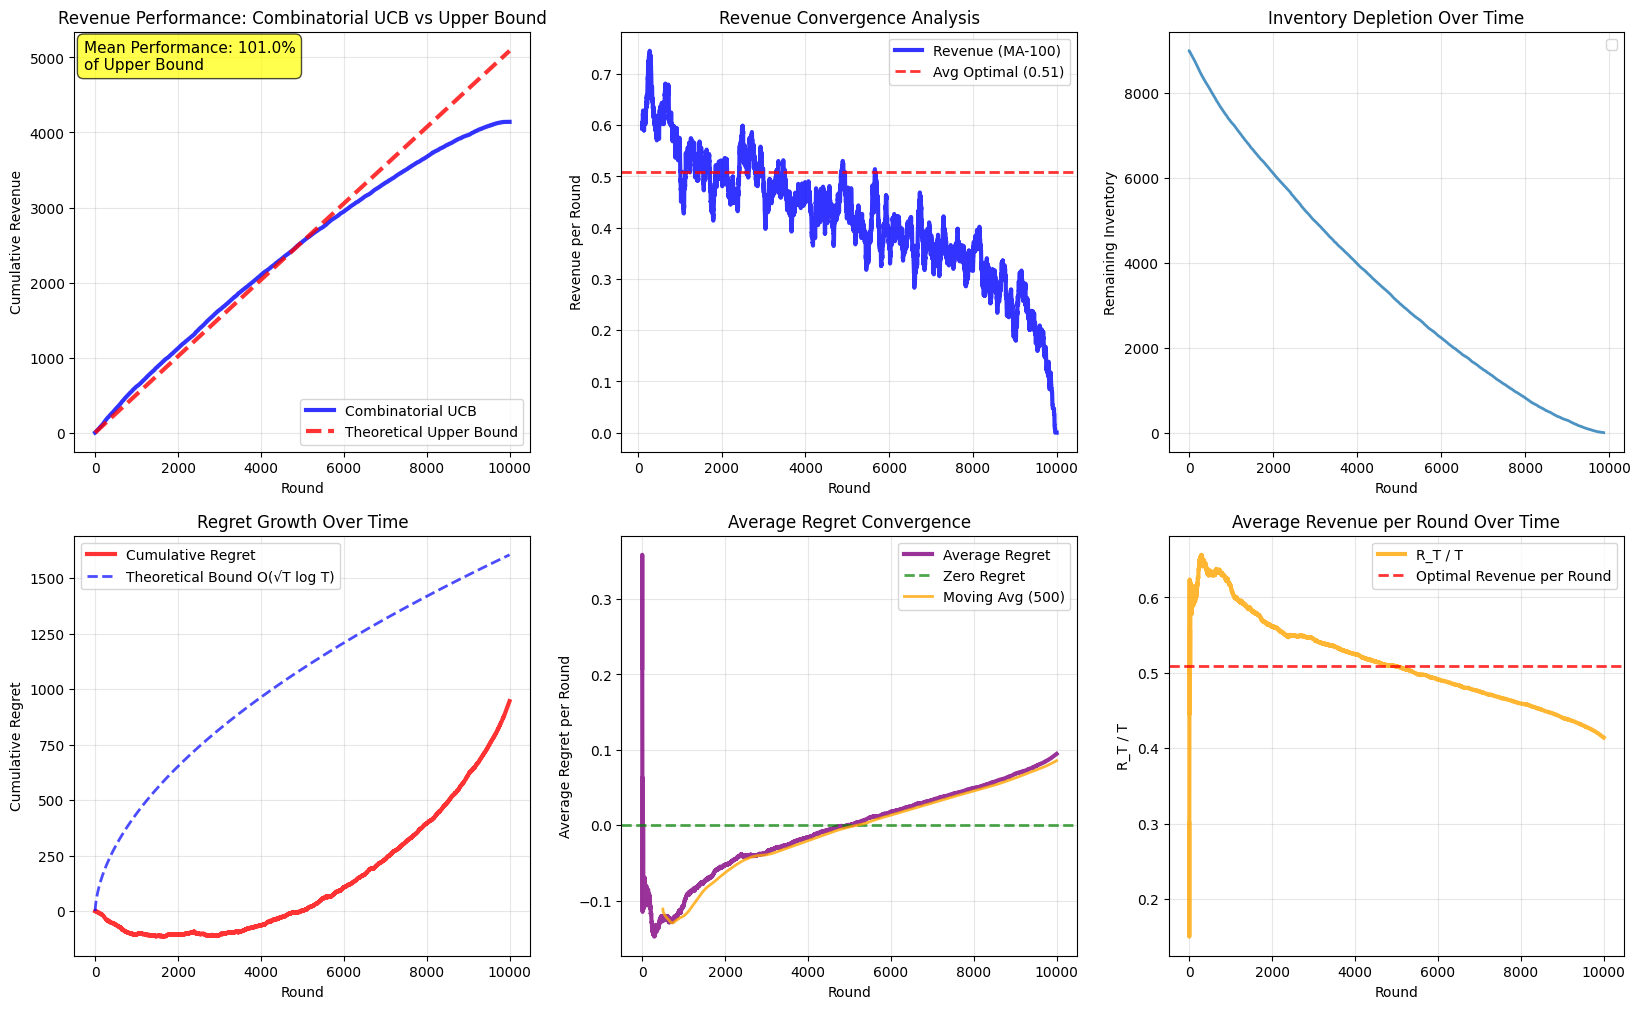

In [133]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

agent_old = CombinatorialUCBWithInventory(
    n_products=n_products,
    price_options=price_options,
    inventory_per_product=inventory_per_product,
    T=T,
    confidence_bound=1.0,  # UCB confidence parameter
    rho_penalty=1.0,       # Penalty factor for inventory constraint
    use_pen_rho=True       # Use penalty factor for inventory constraints
)

agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='sampling')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Agent with 'LINEAR SUM ASSIGNMENT' selection method

In [134]:
optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='lsa')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


Optimal single-product policies:
  Product 0: Price_distribution=[ 0.,  0.,  0.,  0.,  1., -0.,  0.], Revenue/round=0.292
  Product 1: Price_distribution=[ 0.,  0.,  0., -0.,  1.,  0.,  0.], Revenue/round=0.198
  Product 2: Price_distribution=[0.  , 0.  , 0.  , 0.45, 0.55, 0.  , 0.  ], Revenue/round=0.291

Upper bound total revenue: 5088.05
Upper bound avg revenue/round: 0.509



=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 9000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.48, Cumulative =   626.71, Products sold this round = 1, Remaining inventory = 7217
Round 2000: Revenue =   0.60, Cumulative =  1215.61, Products sold this round = 1, Remaining inventory = 5715
Round 3000: Revenue =   0.23, Cumulative =  1809.97, Products sold this round = 1, Remaining inventory = 4229
Round 4000: Revenue =   1.18, Cumulative =  2407.15, Products sold this round = 3, Remaining inventory = 2677
Round 5000: Revenue =   0.96, Cumulative =  2897.38, Products sold this round = 2, Re

C:\Users\marce\AppData\Local\Temp\ipykernel_2004\2345623096.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 2].legend()


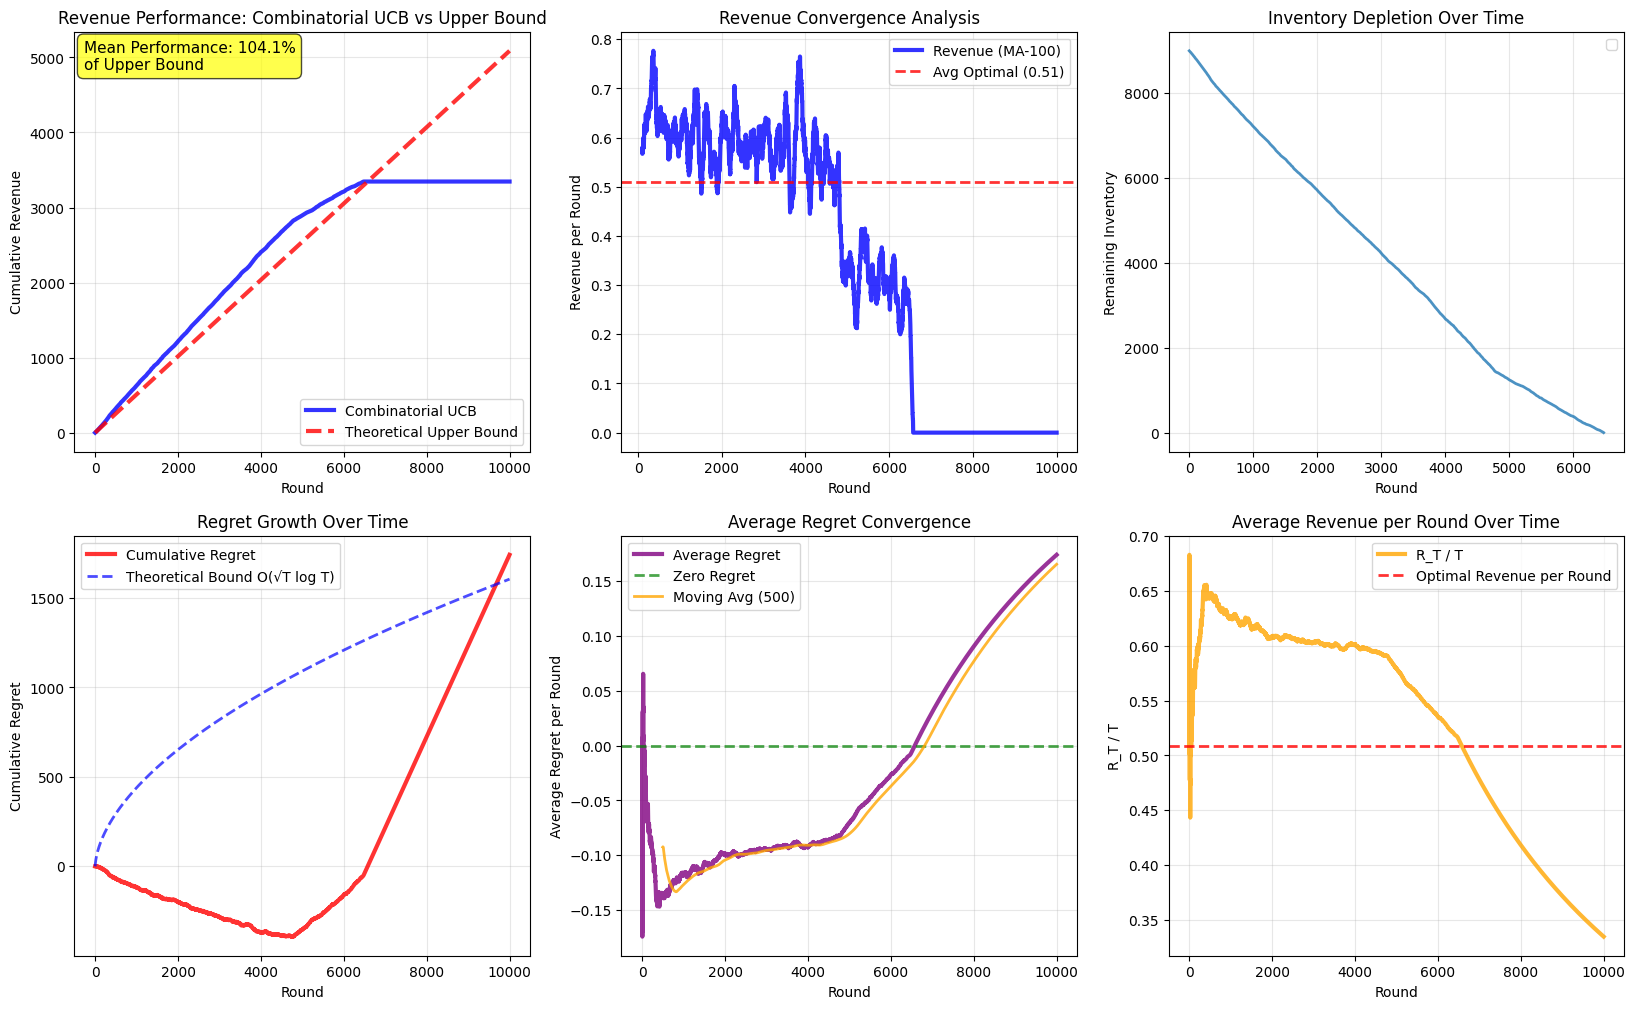

In [135]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

agent_old = CombinatorialUCBWithInventory(
    n_products=n_products,
    price_options=price_options,
    inventory_per_product=inventory_per_product,
    T=T,
    confidence_bound=1.0,  # UCB confidence parameter
    rho_penalty=1.0,       # Penalty factor for inventory constraint
    use_pen_rho=True       # Use penalty factor for inventory constraints
)

agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='lsa')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# High Budget -> 90% of the total T

In [136]:
# Experimental Configuration
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Environment parameters
n_products = 3  # Number of different products
# Create different valuation distributions for each product
valuation_distributions = [
    stats.norm(loc=0.6, scale=0.1),  # Product 0: Higher value, lower variance
    stats.norm(loc=0.4, scale=0.15), # Product 1: Medium value, medium variance
    stats.norm(loc=0.5, scale=0.08)  # Product 2: Medium-high value, low variance
]


# Inventory constraints per product
inventory_per_product = [int(T * 0.1), int(T * 0.05), int(T * 0.15)]  # Different inventory levels
inventory=T*0.9*n_products  # Total inventory across all products


# Price options (same for all products for simplicity)
epsilon = min(inventory_per_product)**(-1/3)  # Number of price options based on epsilon
price_options = np.arange(0.1, 0.9, step=epsilon)  # [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]


print("=== Experimental Setup ===")
print(f"Number of products: {n_products}")
print(f"Time horizon: {T} rounds")
print(f"Price options: {price_options}")
print(f"Initial inventory: {inventory_per_product}")
print(f"Total inventory: {sum(inventory_per_product)}")

# Product valuation info
print("\nProduct valuation distributions:")
for i, dist in enumerate(valuation_distributions):
    print(f"  Product {i}: Normal(μ={dist.mean():.2f}, σ={dist.std():.3f})")

# Create environment
environment = MultiProductPricingEnvironment(valuation_distributions)

# Compute theoretical optimal
print("\n=== Computing Theoretical Optimal ===")
# optimal_policy = compute_optimal_policy(
#     environment, price_options, inventory_per_product, T
# )

optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='sampling')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


=== Experimental Setup ===
Number of products: 3
Time horizon: 10000 rounds
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Initial inventory: [1000, 500, 1500]
Total inventory: 3000

Product valuation distributions:
  Product 0: Normal(μ=0.60, σ=0.100)
  Product 1: Normal(μ=0.40, σ=0.150)
  Product 2: Normal(μ=0.50, σ=0.080)

=== Computing Theoretical Optimal ===
Optimal single-product policies:
  Product 0: Price_distribution=[ 0.,  0., -0.,  1.,  0.,  0.,  0.], Revenue/round=0.425
  Product 1: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.220
  Product 2: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.341

Upper bound total revenue: 9856.88
Upper bound avg revenue/round: 0.986


# Agent with 'SAMPLING' selection method


=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 27000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   0.45, Cumulative =   706.27, Products sold this round = 2, Remaining inventory = 24948
Round 2000: Revenue =   1.18, Cumulative =  1508.17, Products sold this round = 3, Remaining inventory = 22712
Round 3000: Revenue =   0.35, Cumulative =  2367.48, Products sold this round = 1, Remaining inventory = 20411
Round 4000: Revenue =   0.83, Cumulative =  3249.02, Products sold this round = 2, Remaining inventory = 18035
Round 5000: Revenue =   1.31, Cumulative =  4156.23, Products sold this round = 

C:\Users\marce\AppData\Local\Temp\ipykernel_2004\2345623096.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 2].legend()


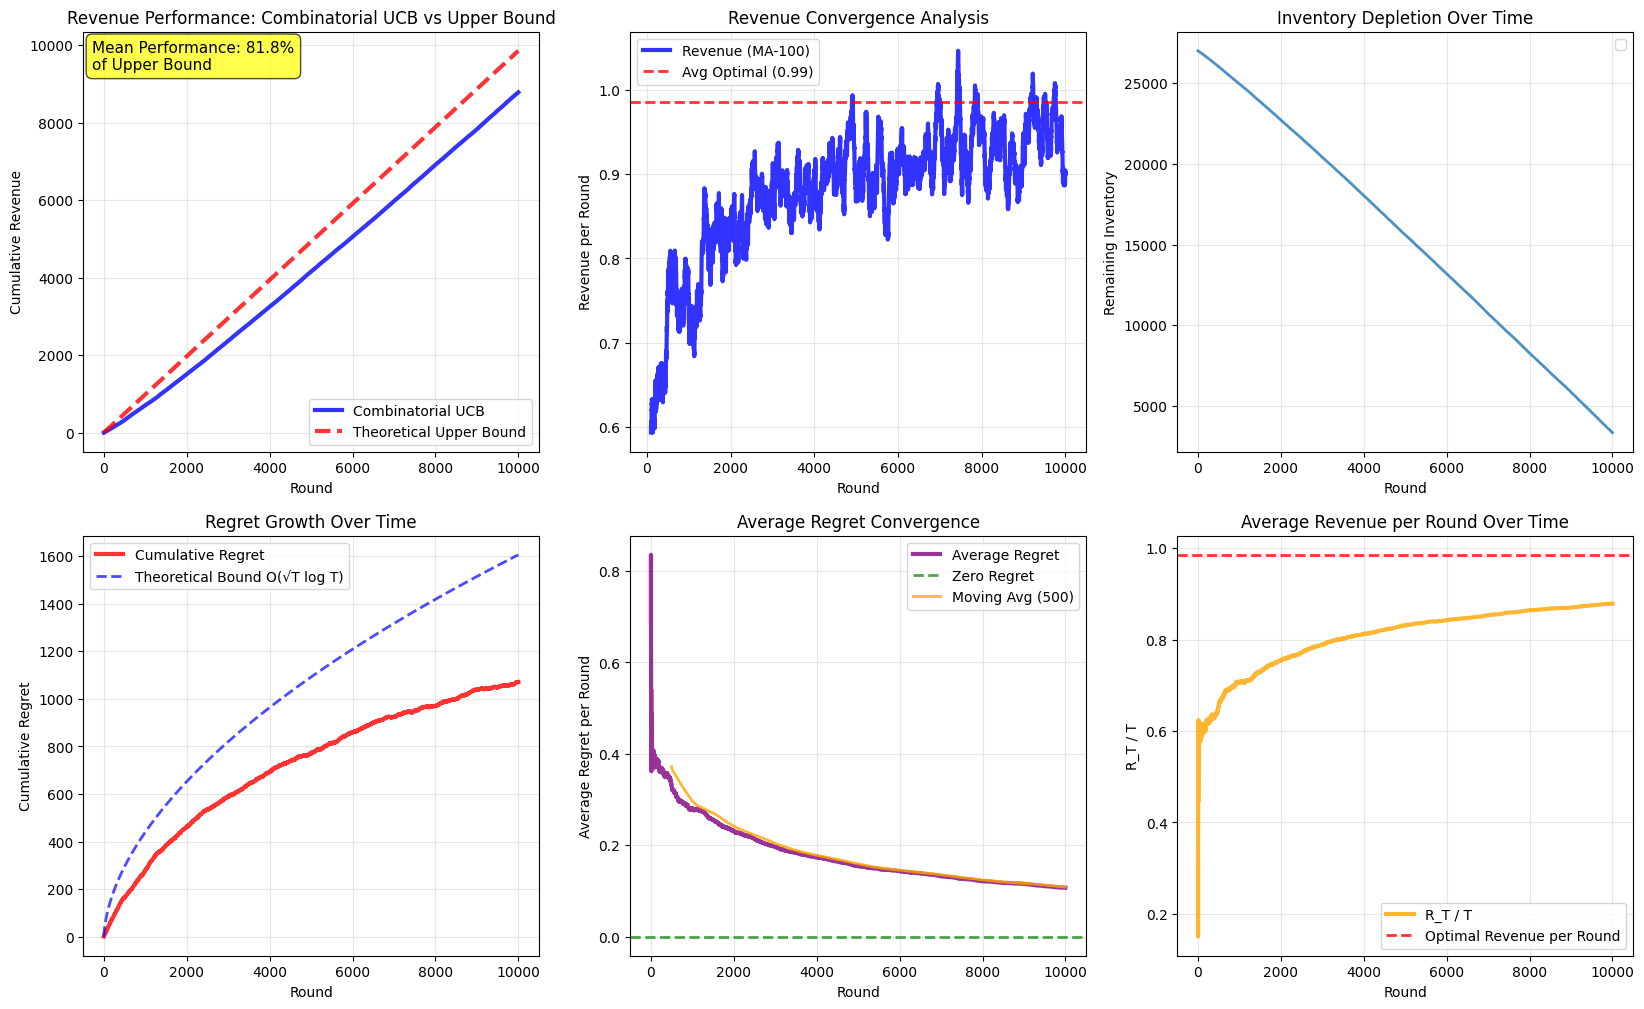

In [137]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

agent_old = CombinatorialUCBWithInventory(
    n_products=n_products,
    price_options=price_options,
    inventory_per_product=inventory_per_product,
    T=T,
    confidence_bound=1.0,  # UCB confidence parameter
    rho_penalty=1.0,       # Penalty factor for inventory constraint
    use_pen_rho=True       # Use penalty factor for inventory constraints
)

agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='sampling')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")

# Agent with 'LINEAR SUM ASSIGNMENT' selection method

In [138]:
optimal_policy=compute_clairvoyant_enhanced(price_options, environment, T, inventory,method='lsa')
optimal_total_revenue=optimal_policy['total_expected_revenue_upper_bound']

#optimal_policy=compute_clairvoyant_sampling(price_options, environment, T, inventory, n_samples=1000000)
#total_revenue_per_round=optimal_policy['mean_optimal_revenue']


# ...existing code...
print("Optimal single-product policies:")

for product_idx, policy in optimal_policy['per_product_policies'].items():
    # Format the price distribution as a string with 2 decimals per value
    price_dist_str = np.array2string(policy['optimal_price_distribution'], precision=2, separator=', ')
    print(f"  Product {product_idx}: Price_distribution={price_dist_str}, "
           f"Revenue/round={policy['expected_revenue_per_round']:.3f}")

print(f"\nUpper bound total revenue: {optimal_policy['total_expected_revenue_upper_bound']:.2f}")
print(f"Upper bound avg revenue/round: {optimal_policy['total_expected_revenue_upper_bound']/T:.3f}")


Optimal single-product policies:
  Product 0: Price_distribution=[ 0.,  0., -0.,  1.,  0.,  0.,  0.], Revenue/round=0.425
  Product 1: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.198
  Product 2: Price_distribution=[0., 0., 1., 0., 0., 0., 0.], Revenue/round=0.341

Upper bound total revenue: 9856.88
Upper bound avg revenue/round: 0.986



=== Creating Combinatorial UCB Agent with LP-based Action Selection ===
Agent initialized with:
  Confidence bound: 1
  Rho penalty factor: 1
  Use penalty rho: False
  Products: 3
  Price options per product: 7
  Total product-price combinations: 21

=== Running Simulation ===
=== Running Combinatorial UCB Simulation for 10000 rounds ===
Products: 3
Initial inventory: 27000.0
Price options: [0.1        0.2259921  0.35198421 0.47797631 0.60396842 0.72996052
 0.85595263]
Round 1000: Revenue =   1.06, Cumulative =   717.79, Products sold this round = 3, Remaining inventory = 24853
Round 2000: Revenue =   0.83, Cumulative =  1545.69, Products sold this round = 2, Remaining inventory = 22415
Round 3000: Revenue =   1.06, Cumulative =  2419.11, Products sold this round = 3, Remaining inventory = 19872
Round 4000: Revenue =   0.58, Cumulative =  3312.40, Products sold this round = 2, Remaining inventory = 17303
Round 5000: Revenue =   0.58, Cumulative =  4225.59, Products sold this round = 

C:\Users\marce\AppData\Local\Temp\ipykernel_2004\2345623096.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 2].legend()


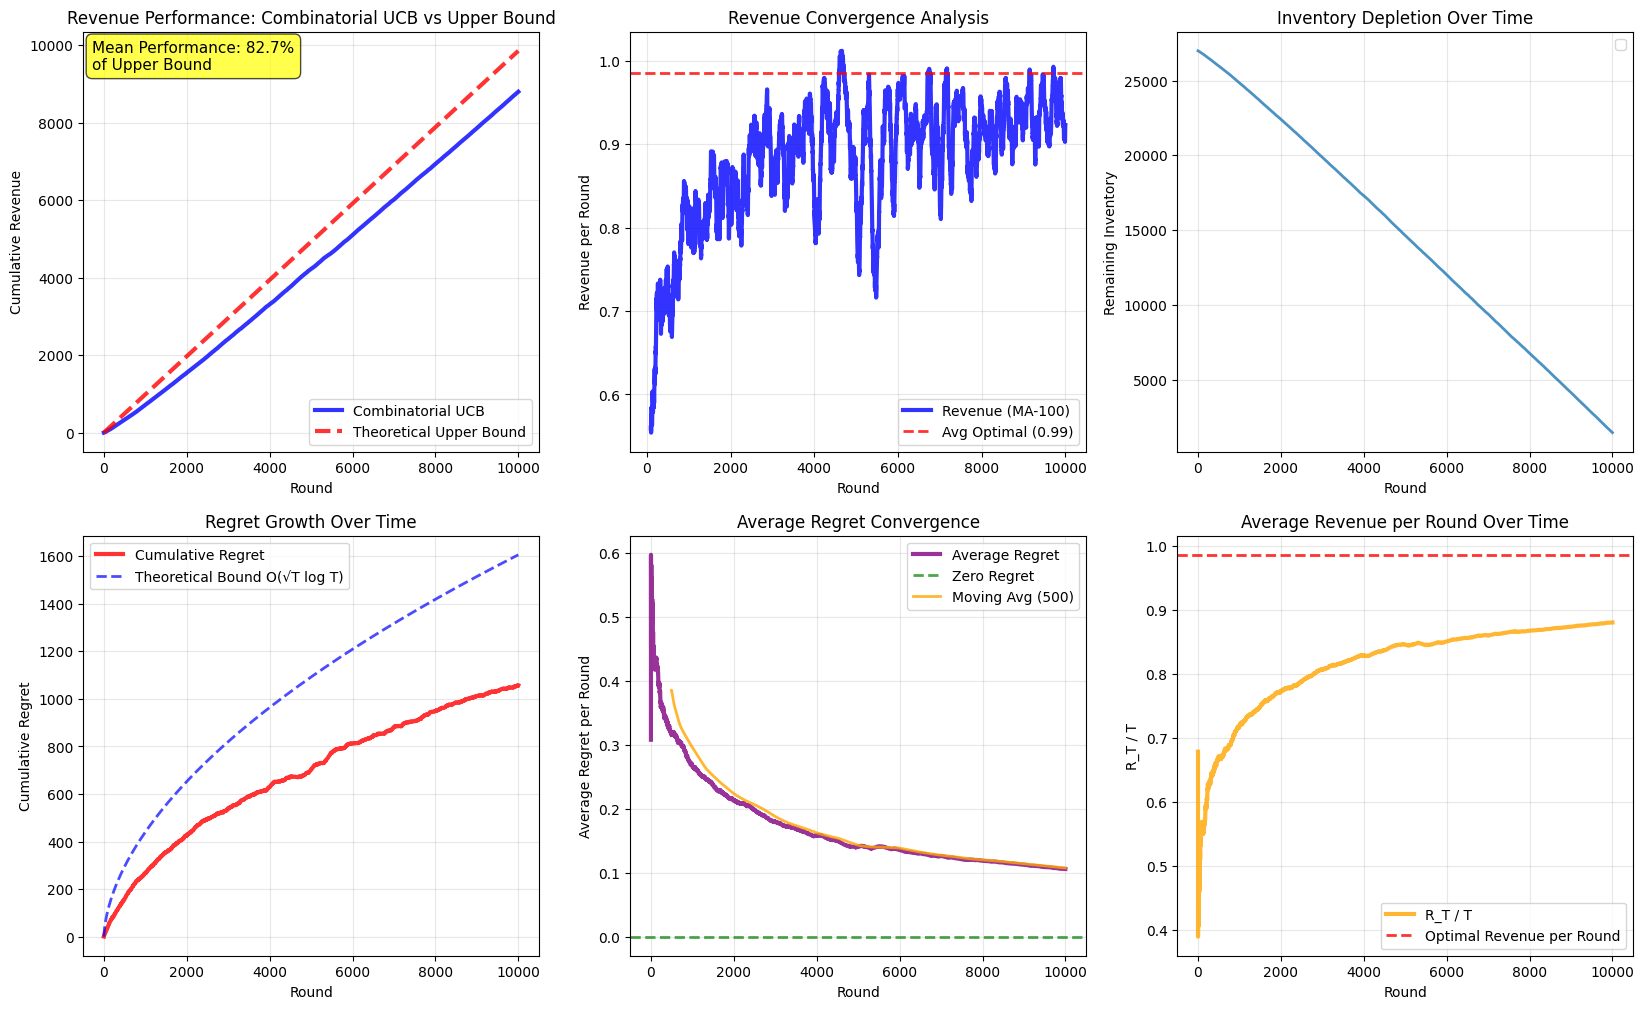

In [139]:
# Create and run Combinatorial UCB agent_new
print("\n=== Creating Combinatorial UCB Agent with LP-based Action Selection ===")

agent_old = CombinatorialUCBWithInventory(
    n_products=n_products,
    price_options=price_options,
    inventory_per_product=inventory_per_product,
    T=T,
    confidence_bound=1.0,  # UCB confidence parameter
    rho_penalty=1.0,       # Penalty factor for inventory constraint
    use_pen_rho=True       # Use penalty factor for inventory constraints
)

agent_new=UCBMatchingAgent(
    n_products=n_products,
    price_options=price_options,
    inventory=inventory,
    T=T,
    confidence_bound=1,
    rho_penalty=1,
    use_pen_rho=False,selection_method='lsa')


print(f"Agent initialized with:")
print(f"  Confidence bound: {agent_new.confidence_bound}")
print(f"  Rho penalty factor: {agent_new.rho_penalty}")
print(f"  Use penalty rho: {agent_new.use_pen_rho}")
print(f"  Products: {agent_new.n_products}")
print(f"  Price options per product: {len(agent_new.price_options)}")
print(f"  Total product-price combinations: {agent_new.n_products * len(agent_new.price_options)}")

# Run simulation
print("\n=== Running Simulation ===")
results = run_combinatorial_simulation(environment, agent_new, T, verbose=True)

# Visualize and analyze results
print("\n=== Analyzing Results ===")

analysis_results = plot_combinatorial_results(results, optimal_policy,optimal_total_revenue, T, environment)

# Additional detailed analysis
print("\n=== Detailed Performance Analysis ===")

# Regret analysis
#optimal_total = optimal_policy['total_expected_revenue_upper_bound']
optimal_total=optimal_total_revenue
actual_total = results['total_revenue']
total_regret = optimal_total - actual_total
avg_regret_per_round = total_regret / T

print(f"Total regret: {total_regret:.2f}")
print(f"Average regret per round: {avg_regret_per_round:.4f}")
print(f"Regret as % of optimal: {100 * total_regret / optimal_total:.2f}%")

# # Inventory analysis
# print(f"\nInventory utilization by product:")
# for i in range(n_products):
#     used = inventory_per_product[i] - results['final_inventory'][i]
#     utilization = 100 * used / inventory_per_product[i]
#     print(f"  Product {i}: {used:.0f}/{inventory_per_product[i]} = {utilization:.1f}%")

# Action space exploration
unique_actions = set()
for action in agent_new.history['actions']:
    product_subset, price_indices = action
    if product_subset:  # Ignore empty actions
        unique_actions.add(tuple(sorted(zip(product_subset, price_indices))))

print(f"\nExploration statistics:")
print(f"  Unique actions tried: {len(unique_actions)}")
print(f"  Total product-price combinations: {n_products * len(price_options)}")
print(f"  Average actions per round: {len(agent_new.history['actions']) / T:.2f}")

# Revenue distribution analysis
revenue_per_round = np.array(results['revenue_per_round'])
print(f"\nRevenue statistics:")
print(f"  Mean revenue per round: {np.mean(revenue_per_round):.3f}")
print(f"  Std revenue per round: {np.std(revenue_per_round):.3f}")
print(f"  Max revenue in single round: {np.max(revenue_per_round):.3f}")
print(f"  Rounds with zero revenue: {np.sum(revenue_per_round == 0)} ({100*np.sum(revenue_per_round == 0)/T:.1f}%)")

print(f"\n=== Final Summary ===")
print(f"Combinatorial UCB achieved {analysis_results['final_performance_pct']:.1f}% of theoretical upper bound")
print(f"Overall inventory utilization: {100*analysis_results['inventory_utilization']:.1f}%")